In [1]:
import numpy as np
import matplotlib.pyplot as plt

import limpy.lines as ll
import limpy.powerspectra as lp
import limpy.params as p
import limpy.utils as lu
from limpy.plotsettings import *

In [2]:
sfr_model, line_lum_models = lu.model_avail(line_name="CII158")
print("Available models for sfr --->", sfr_model)

print("Available models for sfr --->", line_lum_models)

Available models for sfr ---> ['Behroozi19', 'Tng300', 'Tng100', 'Silva15', 'Fonseca16']
Available models for sfr ---> ['Visbal10', 'Silva15-m1', 'Silva15-m2', 'Silva15-m3', 'Silva15-m4', 'Fonseca16', 'Lagache18', 'Schaerer20', 'Alma_scalling']


In [3]:
halo_file ="../limpy/data/" + 'halos_L205_z7.00.npz'

In [4]:
!pwd

/Users/anirbanroy/Documents/Limpy_v2/examples


In [5]:
import limpy.cosmos as cosmos
cosmo_setup=cosmos.cosmo()
small_h = cosmo_setup.h

### Upload halo catalogue and make intensity maps

Limpy can paint line intensities on external halo catalogue. 
The catalogue file should be in npz format and the columns should be saved as ['m', 'x', 'y', 'z']. 
The units are in Msun/h, Mpc/h, Mpc/h, Mpc/h units. 

---> halocat_type="input_cat" assumes this convention. 

In [7]:
# Let's download a sample halo catalogue
#halo_file = "../data/" + 'halos_L205_z7.00.npz'

# load it and check the quantities
hf = np.load(halo_file)

# Read the quantities
mass = hf ['m']
x = hf ['x']
y = hf ['y']
z = hf ['z']

print("The maximum value of mass--->", mass.max())
print("The mainimum value of mass--->", mass.min())

NameError: name 'np' is not defined

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x,y)

NameError: name 'x' is not defined

### Make an intensity grid using the halo catalog

In [7]:
# cross CII_280 * CO54 (90)
z = 7.00  # redshift of catalog
line_name = "CII158" # line name that you want to paint

model_name="Fonseca16"  # line luminosity model name
sfr_model="Silva15" # sfr model name 
mmin=1e11              # minimum mass of the halos
small_h = 0.68         # value of Hubble parameter. H0 = 100 * small_h
halocat_file_type="input_cat" # 
ngrid= 256             # numer of grid points along the all three exes
boxsize = 205          # Length of the box 


# make intensity grid
Igcal=ll.make_intensity_grid(halo_file, 
                           z,
                           sfr_model=sfr_model,
                           model_name= model_name,
                           line_name = line_name, 
                           halo_cutoff_mass= mmin, 
                           halocat_type=halocat_file_type,
                           ngrid_x = ngrid, 
                           ngrid_y = ngrid, 
                           ngrid_z = ngrid, 
                           boxsize_x=boxsize,
                           boxsize_y=boxsize,
                           boxsize_z=boxsize)


In [8]:
print("The shape of the grid is ", np.shape(Igcal))

The shape of the grid is  (256, 256, 256)


### calculate the 3D power spectrum and plot it

The function can calculate the power spectrum of both cube and rectangular box. If boxsize and ngrids 
are different along three axes, then the function "get_pk3d" will assume it as a rectangular box.

In [9]:
kcal, pkcal = lp.get_pk3d(
                            Igcal,
                            boxsize,
                            boxsize,
                            boxsize,
                            ngrid,
                            ngrid,
                            ngrid )

(0.030649684425266274, 3.923159606434083)

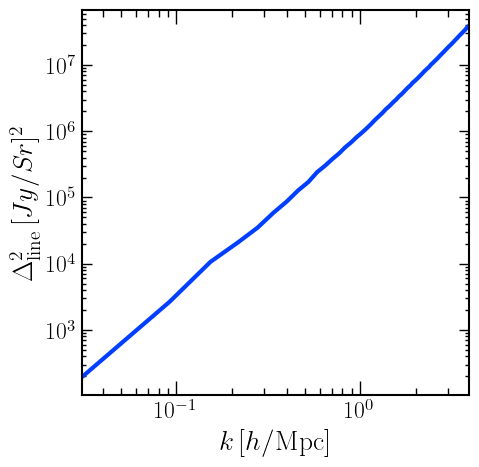

In [10]:
# Plot the power spectrum

fig = plt.figure(figsize=(5, 5), dpi=100)
ax=fig.add_subplot(111)

KF = 2* np.pi/boxsize
KN = np.pi * ngrid/boxsize

ax.loglog(kcal, lu.dk(kcal, pkcal), lw=3)

plt.ylabel(r"$\Delta^2_{\rm line} \, [Jy/Sr]^2$")
plt.xlabel(r"$k\, [h/\mathrm{Mpc}]$")

plt.xlim(KF, KN)


### Intensity grid after beam convolution.

make intensity grid after performing beam convolution. For this case, we need to pass 
three more extra parameters, the observational frequency in GHz, frequency resolution in GHz, and 
the beam size (FWHM) in arc-minute. 

In [11]:
nu_obs = 220 # the observational frequency 
dnu_obs = 2.2 # frequency resolution
fwhm_arcmin = 4.5 # FWHM of beam in arc-minute

Ig_beam=ll.make_intensity_grid(halo_file, 
                           z,
                           sfr_model=sfr_model,
                           model_name= model_name,
                           line_name = line_name, 
                           halo_cutoff_mass= mmin, 
                           halocat_type=halocat_file_type,
                           ngrid_x = ngrid, 
                           ngrid_y = ngrid, 
                           ngrid_z = ngrid, 
                           boxsize_x=boxsize,
                           boxsize_y=boxsize,
                           boxsize_z=boxsize,
                           nu_obs = nu_obs,
                           dnu_obs = dnu_obs,
                           theta_fwhm = fwhm_arcmin)


5966.369817578885
5987.534137906463
6008.349648472868
6028.825796082241
6048.971674621256
6068.796041749707
6088.307334641866
6107.513684841335
6126.422932287375
6145.042638566504


when we apply beam convolution, the code changes the number grid points along the z-axis 
(by convensition axis = 2) according to the frequency resolution $\delta \nu_{\rm obs}$.

In [12]:
# calculate the power spectrum
ngrid_new = np.shape(Ig_beam)[2]

kb, pkb = lp.get_pk3d(
    Ig_beam,
    boxsize,
    boxsize,
    boxsize,
    ngrid,
    ngrid,
    ngrid_new)

### plot intensity maps

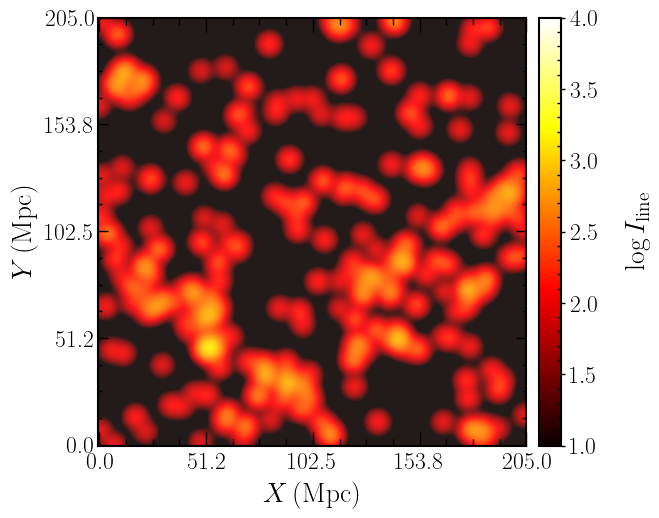

In [13]:
# Let's make a slice plot using the built-in plotting function "plot_beam_convolution".

ll.plot_beam_convolution(Ig_beam[:,:,0], ngrid, boxsize, 
                           z, cmap="hot", plot_scale="log", vmax=10000, vmin=10)

In [14]:
# make maps with 0.5 arc-min beam size
fwhm_arcmin = 0.5
Ig_beam1=ll.make_intensity_grid(halo_file, 
                           z,
                           sfr_model=sfr_model,
                           model_name= model_name,
                           line_name = line_name, 
                           halo_cutoff_mass= mmin, 
                           halocat_type=halocat_file_type,
                           ngrid_x = ngrid, 
                           ngrid_y = ngrid, 
                           ngrid_z = ngrid, 
                           boxsize_x=boxsize,
                           boxsize_y=boxsize,
                           boxsize_z=boxsize,
                           nu_obs = nu_obs,
                           dnu_obs = dnu_obs,
                           theta_fwhm = fwhm_arcmin)


5966.369817578885
5987.534137906463
6008.349648472868
6028.825796082241
6048.971674621256
6068.796041749707
6088.307334641866
6107.513684841335
6126.422932287375
6145.042638566504


In [15]:
# check the modified ngrid along the z-axis due to the effect of delta_nu_obs
ngrid_new = np.shape(Ig_beam1)[2]


# calculate the power spectrum
kb1, pkb1 = lp.get_pk3d(
    Ig_beam1,
    boxsize,
    boxsize,
    boxsize,
    ngrid,
    ngrid,
    ngrid_new)

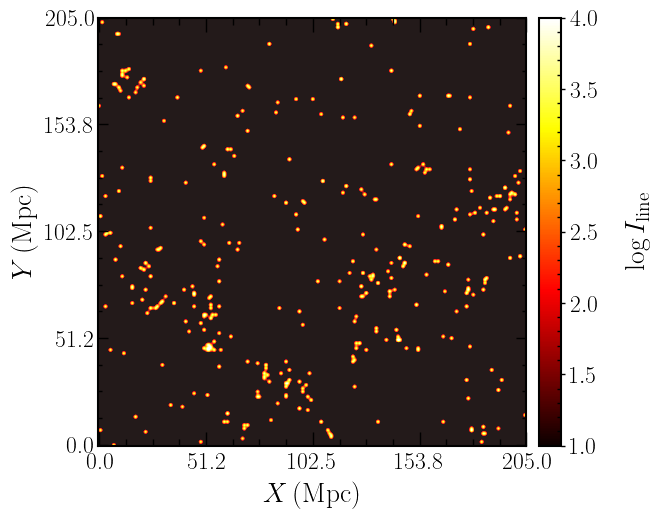

In [16]:
ll.plot_beam_convolution(Ig_beam1[:,:,0], ngrid, boxsize, z, cmap="hot", plot_scale="log", vmax=10000, vmin=10)

Text(0.5, 0, '$k\\, [h/\\mathrm{Mpc}]$')

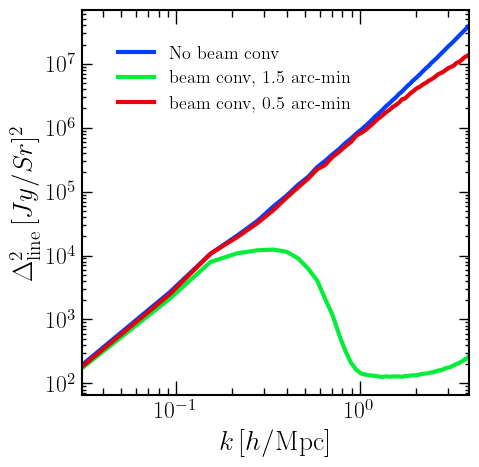

In [17]:
plt.loglog(kcal, lu.dk(kcal, pkcal), lw=3, label = "No beam conv")
plt.loglog(kb, lu.dk(kb, pkb), lw=3, label = "beam conv, 1.5 arc-min")
plt.loglog(kb1, lu.dk(kb1, pkb1), lw=3, label = "beam conv, 0.5 arc-min")

plt.legend(loc=0, frameon=False)


plt.xlim(KF, KN)
plt.ylabel(r"$\Delta^2_{\rm line} \, [Jy/Sr]^2$")
plt.xlabel(r"$k\, [h/\mathrm{Mpc}]$")


### Calculate the error on the power spectrum in the presence of white noise only. 

In [18]:
bin_num = 6 # number of bins
pk_noise = 4e9 #take simple white noise power spectrum in Jy/Sr * Mpc^3

Vsurv = lu.V_survey(z, dnu_obs=2.8, area= 16, line_name = "CII158") # volume of the survey

# calculate the 
kbin, pkbin, pkerr = lp.pk_error(kcal, pkcal, pk_noise, Vsurv, bin_num = bin_num, binning_scheme = "log")

Text(0.5, 0, '$k\\, [h/\\mathrm{Mpc}]$')

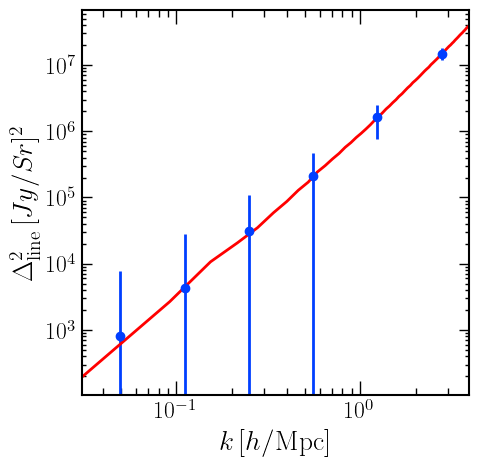

In [19]:
plt.errorbar(kbin, lu.dk(kbin, pkbin), yerr = lu.dk(kbin, pkerr ), fmt ='', lw=2,  marker = "o", ls='none')
plt.plot(kcal, lu.dk (kcal, pkcal), lw= 2, color ="red")

plt.yscale("log")
plt.xscale("log")

plt.xlim(KF, KN)
plt.ylabel(r"$\Delta^2_{\rm line} \, [Jy/Sr]^2$")
plt.xlabel(r"$k\, [h/\mathrm{Mpc}]$")

### Introduce Z evolution

If the box size is very large along the redshift axis, the code can introduce the
evolution of sfr along the refshift axis. 

In [20]:
Ig_zevo=ll.make_intensity_grid(halo_file, 
                           z,
                           sfr_model=sfr_model,
                           model_name= model_name,
                           line_name = line_name, 
                           halo_cutoff_mass= mmin, 
                           halocat_type=halocat_file_type,
                           ngrid_x = ngrid, 
                           ngrid_y = ngrid, 
                           ngrid_z = ngrid, 
                           boxsize_x=boxsize,
                           boxsize_y=boxsize,
                           boxsize_z=boxsize,
                           nu_obs = nu_obs,
                           dnu_obs = dnu_obs,
                           theta_fwhm = fwhm_arcmin,
                           z_evolution=True)


0.036630124 20.095888
20.142508 40.18926
40.2366 60.303375
60.372097 80.396095
80.48836 100.40873
100.56993 120.47747
120.62072 140.6854
140.77733 160.81566
160.94112 180.8165
180.96901 201.02347
5966.369817578885
5987.534137906463
6008.349648472868
6028.825796082241
6048.971674621256
6068.796041749707
6088.307334641866
6107.513684841335
6126.422932287375
6145.042638566504


In [21]:

ngrid_new = np.shape(Ig_zevo)[2]
kz, pkz = lp.get_pk3d(
    Ig_zevo,
    boxsize,
    boxsize,
    boxsize,
    ngrid,
    ngrid,
    ngrid_new)

Text(0.5, 0, '$k\\, [h/\\mathrm{Mpc}]$')

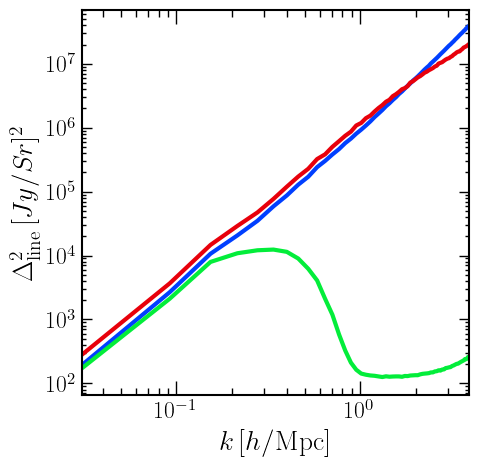

In [22]:
plt.loglog(kcal, lu.dk(kcal, pkcal), lw=3)
plt.loglog(kb, lu.dk(kb, pkb), lw=3)
plt.loglog(kz, lu.dk(kz, pkz), lw=3)

plt.xlim(KF, KN)
plt.ylabel(r"$\Delta^2_{\rm line} \, [Jy/Sr]^2$")
plt.xlabel(r"$k\, [h/\mathrm{Mpc}]$")